In [1]:
import os
import json
import glob
import shutil
import cv2
from math import dist
import numpy as np
import matplotlib.pyplot as plt

In [2]:
degrees = ['15cm_0mm_0deg', '15cm_25mm_5deg', '15cm_50mm_10deg', '20cm_0mm_0deg', '20cm_25mm_5deg', '20cm_50mm_10deg']

In [3]:
result="../7_result"
local_error_dif_deg = "../7_local_error_dif_deg"
return_to_ori_size = "../4_return_to_ori_size"
names = os.listdir(return_to_ori_size)
occlusion = "../9_occlusion_image"

In [5]:
mmpose_result="../../../mmpose/result"
json_ = "../2_json"
return_to_ori_size = "../4_return_to_ori_size"

occlusion = "../9_occlusion_image"
cm = [4.45, 4.74, 3.9, 3.86, 4.20, 4.60, 4.69, 4.75]

test_number = 4

names = os.listdir(mmpose_result)

for n in range(0,len(names)):
    for deg in degrees:
        
        occlusion_name_deg = os.path.join(occlusion, names[n], deg)
        if not os.path.isdir(occlusion_name_deg):
            os.makedirs(occlusion_name_deg)
        
        json_file = os.path.join(json_, names[n], deg, "keypoint_location.json")
        imgs = os.listdir(os.path.join(return_to_ori_size, names[n], deg))
        imgs = sorted( imgs, key = lambda s : int(os.path.splitext(os.path.basename(s))[0]), reverse= False )
        
        interval = len(imgs) / 3
        temp = list(range(len(imgs)))
        index = [temp[0]] + [temp[int(interval)]] + [temp[int(interval*2)]] +[temp[-1]]


        with open(json_file, "r") as f:
            video_frame_kpt = json.load(f)

        for i in index:
            if names[n] == "cather" or names[n] == "jack":
                scale12_x = float(video_frame_kpt["frame_{index}".format(index = i)]["12"]["keypoint_location"][0])
                scale12_y = float(video_frame_kpt["frame_{index}".format(index = i)]["12"]["keypoint_location"][1])

                scale14_x = float(video_frame_kpt["frame_{index}".format(index = i)]["14"]["keypoint_location"][0])
                scale14_y = float(video_frame_kpt["frame_{index}".format(index = i)]["14"]["keypoint_location"][1])

                scale = dist((scale12_x, scale12_y), (scale14_x, scale14_y)) / cm[n]

            else:
                scale0_x = float(video_frame_kpt["frame_{index}".format(index = i)]["0"]["keypoint_location"][0])
                scale0_y = float(video_frame_kpt["frame_{index}".format(index = i)]["0"]["keypoint_location"][1])

                scale11_x = float(video_frame_kpt["frame_{index}".format(index = i)]["11"]["keypoint_location"][0])
                scale11_y = float(video_frame_kpt["frame_{index}".format(index = i)]["11"]["keypoint_location"][1])

                scale = dist((scale0_x, scale0_y), (scale11_x, scale11_y)) / cm[n]
            
            frame = cv2.imread(os.path.join(return_to_ori_size, names[n], deg, "{index}.png".format(index = i)))
            
            if not os.path.isdir(os.path.join(occlusion_name_deg,"{frame_index}".format(frame_index = i))):
                os.makedirs(os.path.join(occlusion_name_deg,"{frame_index}".format(frame_index = i)))
                
            
            
            for j in range(0, len(video_frame_kpt["frame_{index}".format(index = i)])):
                
                copy_frame = frame.copy()
                
                mask_w_h = int(0.7 * scale)
                mask_w_h_half = int(mask_w_h * 0.5)
                
                
                x = video_frame_kpt["frame_{index}".format(index = i)][str(j)]["keypoint_location"][0]
                y = video_frame_kpt["frame_{index}".format(index = i)][str(j)]["keypoint_location"][1]
                left_top = ( x -  mask_w_h_half, y - mask_w_h_half)
                bottom_right = ( x + mask_w_h - mask_w_h_half, y + mask_w_h - mask_w_h_half)
                cv2.rectangle(copy_frame, left_top, bottom_right, 0, thickness=cv2.FILLED)
                cv2.imwrite(os.path.join(occlusion_name_deg,"{frame_index}".format(frame_index = i),"occlusion_{acu_index}.png".format(acu_index=j)),copy_frame)
                





    
            
        

[0.208458736631256, 0.12619645877401342, 0.11420562403790152, 0.15658593256556116, 0.1506929969608419, 0.10923631678221563, 0.14035746138252778, 0.13374997990551624, 0.14518637260409828, 0.15566016443924993, 0.1586967046663314, 0.12233071339209871, 0.19256532153460323, 0.14453100771166283, 0.12707024380416848, 0.0877644765340863, 0.12995564855244573, 0.1633006184919711, 0.10629986756406062, 0.12527149029450016, 0.17533193878716669]


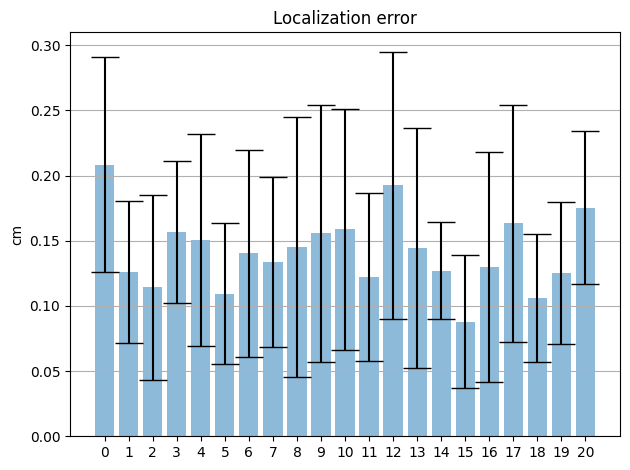

In [8]:
mmpose_result="../../../mmpose/result"

all_name_acu = {}
for i in range(0 ,21):
    all_name_acu[i] = []
for name in os.listdir(mmpose_result):
    mmpose_result_name = os.path.join(mmpose_result, name)
    mmpose_result_name_localization_error = os.path.join(mmpose_result_name, "localization_error")
    with open(os.path.join(mmpose_result_name_localization_error, "localization_error.json"), "r") as localization_error_file:
        localization_error = json.load(localization_error_file)

    for i in range(0 ,len(localization_error)):
        acupoints = np.array(localization_error[str(i)])
        all_name_acu[i].append(np.mean(acupoints))

mean = []
std = []
for i in range(0 ,len(localization_error)):
    mean.append(np.mean(np.array(all_name_acu[i])))
    std.append(np.std(np.array(all_name_acu[i])))

print(mean)
fig, ax = plt.subplots()
ax.bar(np.arange(21), mean, yerr=std, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('cm')
ax.set_xticks(np.arange(21))
ax.set_xticklabels(list(range(0, 21)))
ax.set_title('Localization error')
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
plt.savefig('bar_plot_with_error_bars.png')
plt.show()

In [21]:

mmpose_result="../../../mmpose/result"
original_video = "../0_original_video"
cm = [4.45, 4.74, 3.9, 3.86, 4.20, 4.60, 4.69, 4.75]
names = os.listdir(mmpose_result)

for n in range(0, len(names)):

    mmpose_result_name = os.path.join(mmpose_result, names[n])
    files = glob.glob(os.path.join(mmpose_result_name, "*.json"))
    files = sorted(files, key= lambda s: int(os.path.splitext(os.path.basename(s))[0][5:]), reverse= False)
    
    mmpose_result_name_5_test_json = os.path.join(mmpose_result_name, "5_test_json")
    test_json = os.path.join(mmpose_result_name_5_test_json, "test.json")
    with open(test_json, "r") as file:
        gt_json = json.load(file)

    
    count = 0
    x=0
    for deg in degrees:
        
        resized_video = os.path.join(original_video, names[n], deg, "resize.mp4")
        cap = cv2.VideoCapture(resized_video)
        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        x = x + frame_count

        for i in range(0, frame_count):

            
            all_kpts = {}    
            for k in range(0, 21):
                all_kpts[k] = []
            
            mmpose_result_name_img_pre_json = os.path.join(mmpose_result_name, files[count])
            with open(mmpose_result_name_img_pre_json, "r") as pre_file:
                pre_json = json.load(pre_file)

            pre_keypoints = pre_json["instance_info"][0]["keypoints"]
            gt_keypoints = gt_json["annotations"][count]



            if names[n] == "cather" or names[n] == "jack":
                scale12_x = float(gt_keypoints["keypoints"][36])
                scale12_y = float(gt_keypoints["keypoints"][37])

                scale14_x = float(gt_keypoints["keypoints"][42])
                scale14_y = float(gt_keypoints["keypoints"][43])

                scale = cm[n] / dist((scale12_x, scale12_y), (scale14_x, scale14_y))

            else:
                scale0_x = float(gt_keypoints["keypoints"][0])
                scale0_y = float(gt_keypoints["keypoints"][1])

                scale11_x = float(gt_keypoints["keypoints"][33])
                scale11_y = float(gt_keypoints["keypoints"][34])

                scale = cm[n] / dist((scale0_x, scale0_y), (scale11_x, scale11_y))

            for j in range(0, len(pre_keypoints)):

                if gt_keypoints["keypoints"][3*j + 2 ] == 2:
                    pre_x = pre_keypoints[j][0]
                    pre_y = pre_keypoints[j][1]

                    gt_x = float(gt_keypoints["keypoints"][3*j])
                    gt_y = float(gt_keypoints["keypoints"][3*j + 1])

                    all_kpts[j].append(scale * dist((gt_x, gt_y), (pre_x, pre_y)))
               
            
        
            mmpose_result_name_localization_error = os.path.join(mmpose_result_name, "localization_error", deg)
            if not os.path.isdir(mmpose_result_name_localization_error):
                os.makedirs(mmpose_result_name_localization_error)
            with open(os.path.join(mmpose_result_name_localization_error, "test_{index}.json".format(index = i)), "w") as localization_error_file:
                json.dump(all_kpts, localization_error_file)
            count += 1
    
            
        